## Importando Bibliotecas e Arquivo.

In [1]:
#Importando Bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
# from sklearn.ensemble import GradientBoostingRegressor


In [2]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
#Importando Dataset
df1=pd.read_csv('C:/Users/bruno/OneDrive/Área de Trabalho/Curso Data Expert DNC/AZUL/Amostra DNC titulo.csv')
df1=df1.drop(df1.columns[0],axis=1)
df2=pd.read_csv('C:/Users/bruno/OneDrive/Área de Trabalho/Curso Data Expert DNC/AZUL/Base_Azul_DNC_Abr22.csv')
df=pd.concat([df1,df2])
periodo = pd.read_excel('C:/Users/bruno/OneDrive/Área de Trabalho/Curso Data Expert DNC/AZUL/De_Para_Periodo.xlsx')


C:\Users\bruno\AppData\Local\Temp\ipykernel_28980\2304199085.py:4: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df2=pd.read_csv('C:/Users/bruno/OneDrive/Área de Trabalho/Curso Data Expert DNC/AZUL/Base_Azul_DNC_Abr22.csv')


## Criando Variaveis

In [4]:
#Variavel Faixa horaria - hora cheia extraida do capo DepTime
df['faixa_horaria']=(df['DepTime'].astype('str')).str[:2].astype('int')

#Variavel Chave - Usada na construção de dataFrames auxiliares
df['chave2']=df['Dep Date']+df['Segment']+(df['faixa_horaria'].astype('int')).astype('str')+df['Nest']

#Calculo dos indicadores RASK e Ocupação
df['Rask']=df['Revenue']/df['ASKs']
df['Ocupacao']=df['RPKs']/df['ASKs']

#Unindo o Periodo com o Data Frame
df=pd.merge(df,periodo, on= 'faixa_horaria')



### Ajuste das Variaveis categoricas e de datas

In [5]:
# Ajuste do nome das colunas, retirada de espaços
df=df.rename(columns={'Dep Date':'Dep_Date','Event Name':'Event_Name'})

#Ajustando Variaveis
df['Capture']= df['Capture'].astype('datetime64')
df['Dep_Date']= df['Dep_Date'].astype('datetime64')
# df['Event_Name'] = df['Event_Name'].astype('category')
# df['DOW'] = df['DOW'].astype('category')
# df['Description'] = df['Description'].astype('category')
# df['EquipmentType'] = df['EquipmentType'].astype('category')
# df['NDSegment'] = df['NDSegment'].astype('category')
# df['Segment'] = df['Segment'].astype('category')
# df['Orig'] = df['Orig'].astype('category')
# df['Dest'] = df['Dest'].astype('category')
# df['FlightID'] = df['FlightID'].astype('category')

#Transformação de campo Categorico em Numérico
df['Nest'] = df['Nest'].map({'Y':0, 'C':1})


### Seleção de Features + Transformação de Dados

In [6]:
#Seleção de Dados para construção d modelo

dforiglimpo2 = df[['Capture', 'FlightID', 'NDO', 'Dep_Date', 'Event_Name', 
                   'EvDef',  'DOW', 'Month', 'Description', 'Nest', 
                   'Segment', 'Dest', 'Flts', 'Lid','faixa_horaria', 
                   'chave2', 'Rask', 'Ocupacao', 'Periodo','Distance',
                   'ASKs', 'RPKs', 'Booked', 'NSKBooked', 'GDSBooked', 
                   'TudoAzulBooked','AzulViagensBooked', 'CNXBooked', 'Revenue', 'RevenueNSK', 
                   'RevenueGDS', 'RevenueTudoAzul','RevenueAzulViagens', 'DLRev']]


del df

In [7]:
#Transformação de Variaveis cátegoricas em Numéricas
lab = LabelEncoder()
dforiglimpo2['Event_Name']=lab.fit_transform(dforiglimpo2['Event_Name'])
dforiglimpo2['EvDef']=lab.fit_transform(dforiglimpo2['EvDef'])
dforiglimpo2['DOW']=lab.fit_transform(dforiglimpo2['DOW'])
dforiglimpo2['Description']=lab.fit_transform(dforiglimpo2['Description'])
dforiglimpo2['Month']=lab.fit_transform(dforiglimpo2['Month'])


In [8]:
# Transformação de campos numéricos em campos Escalonados

Scaler = StandardScaler()

#atribuição dos campos em uma nova variavel
tranformar=dforiglimpo2[['ASKs','RPKs','Revenue','RevenueNSK','RevenueGDS','RevenueTudoAzul','RevenueAzulViagens','DLRev']]

#Transformação ds campos da nova Variavel
transformadas=Scaler.fit_transform(tranformar)

#Substituição dos campos originais pelos transformados
dforiglimpo2['ASKs']=transformadas[:,0]
dforiglimpo2['RPKs']=transformadas[:,1]
dforiglimpo2['Revenue']=transformadas[:,2]
dforiglimpo2['RevenueNSK']=transformadas[:,3]
dforiglimpo2['RevenueGDS']=transformadas[:,4]
dforiglimpo2['RevenueTudoAzul']=transformadas[:,5]
dforiglimpo2['RevenueAzulViagens']=transformadas[:,6]
dforiglimpo2['DLRev']=transformadas[:,7]

### Seleção de uma data de Captura / definição de amostra aleatória

In [9]:
# Seleção de um Dia especifico de Venda, representação de rodada do modelo em produção com dados em D-1
dfTeste=dforiglimpo2[dforiglimpo2['Capture']=='2022-07-13']
dfTeste=pd.DataFrame(dfTeste).reset_index()
x=int((dfTeste.shape[0])*0.01)
dfTeste=dfTeste.sample(x,replace=True)
x

263

### Criação de Feature para identificação de Voos Finalizados

In [10]:
#Atribuição da Data de Capture selecionada na ação anterior a uma nova variavel
data=dfTeste['Capture'].max()

#Identificação de Voos que estejam com data anterior a data selecionada
grava_fim=dforiglimpo2.loc[(dforiglimpo2['Capture']<=data)]

#Seleção de / Atribuição dos voos anteriores a data selecionada e que já tenham sido finalizados (NDO = -1)
grava_fim=grava_fim.query('NDO==-1')

#Criação de um novo campo na nova variavel criada para identificação dos voos já finalizados
grava_fim['Finalizado']=1

#Seleção dos dois campos que serão usados na base final do modelo 
grava_fim=grava_fim[['chave2','Finalizado']]

#União dos dados recem gerados com a base principal do modelo
dforiglimpo2=pd.merge(dforiglimpo2, grava_fim, how='left', on='chave2')

### Aplicação de Modelos

In [11]:
#Variavel Vazia para receber o resultado da Predição
base=[]

#for para percorrer todas as linhas da base selecionada / Definição de Variaveis para Filtros
for i in range(len(dfTeste)):#len(dfTeste)
     
     lin=dfTeste.iloc[i]
     a=lin['NDO']
     b=lin['Dep_Date']
     # c=lin['FlightID']
     c=lin['Segment']
     d=lin['Periodo']
     e=lin['Ocupacao']
     f=lin['Flts']
     g=lin['chave2']
     h=lin['Nest']
     j=lin['Dest']
     k=lin['DOW']
     m=lin['Capture']
     n=lin['Rask']


     print(i)

     try:

          try:
               #Filtro de linhas que possuem a mesma caracteristica da linha selecionada anteriormente
               subdf1=dforiglimpo2.loc[(dforiglimpo2['NDO']==a) & (dforiglimpo2['Dep_Date'].values<=b) & (dforiglimpo2['Segment']==c) &
               (dforiglimpo2['Periodo']==d)&(dforiglimpo2['Nest']==h)&(dforiglimpo2['Capture']<=m)&(dforiglimpo2['Finalizado']==1)]
               
               #Seleção dos dados referente ao voo que será previsto
               subdfpred=dforiglimpo2.loc[(dforiglimpo2['chave2'].values==g)&(dforiglimpo2['Capture']==m)]

               #Concatenação dos dados históricos com os dados que serão previstos
               subdf1=pd.concat([subdfpred,subdf1])

               #Filtro de linhas com as mesma caracteristica da linha selecionada anteriormente, porem com NDO = -1 para definição da Variavel Y
               subdf2=dforiglimpo2.loc[(dforiglimpo2['NDO']==-1) & (dforiglimpo2['Dep_Date'].values<b) & (dforiglimpo2['Segment']==c) & 
                                   (dforiglimpo2['Periodo']==d)&(dforiglimpo2['Nest']==h)]
               
               #Sepação dos dados que serão usados como Variavel Y nas duas Previsões (Ocupação e Rask)
               y=subdf2[['chave2','Ocupacao', 'Rask']]

               #Merge das informações X e Y
               subdf3=pd.merge(subdf1,y,how='left',on='chave2')

               #Definição das Variaveis que serão apagadas do modelo
               subdf_Ocupacao=subdf3[[  'Event_Name', 'EvDef',  'DOW','Month', 'Description', 'chave2', 'Ocupacao_x', 'RPKs', 'Booked','Revenue',  'Finalizado', 'Ocupacao_y', ]]                              


               subdf_Ocupacao=subdf_Ocupacao.set_index('chave2')


               N_Linhas=len(subdf_Ocupacao)
          
               #Definição de Base de Teste
               pred1=subdf_Ocupacao.loc[(subdf_Ocupacao['Finalizado']!=1)]
               
               #Definição de Base de Treino
               subdf_Ocupacao=subdf_Ocupacao.loc[(subdf_Ocupacao['Finalizado']==1)]  
               
               
               #Definição de x e y para o modelo - Previsão Ocupação
               y= np.array(subdf_Ocupacao['Ocupacao_y'])
               x=subdf_Ocupacao.drop(['Ocupacao_y','Finalizado'], axis = 1) 
               pred1=pred1.drop(columns=['Ocupacao_y','Finalizado'], axis = 1)
               x_list = list(x.columns)
               x = np.array(x)
               pred1 = np.array(pred1)

               
               

               #Definição de x e y para o modelo - Previsão Rask
               subdf_Rask=subdf3[[ 'Event_Name', 'EvDef', 'DOW', 'Month', 'Description', 'Nest', 'chave2', 'Rask_x', 'RPKs', 'Booked', 'CNXBooked', 'Revenue', 'Finalizado','Rask_y' ]]


               subdf_Rask=subdf_Rask.set_index('chave2')
               #Definição de Base de Teste
               pred2=subdf_Rask.loc[(subdf_Rask['Finalizado']!=1)]
               
               #Definição de Base de Treino
               subdf_Rask=subdf_Rask.loc[(subdf_Rask['Finalizado']==1)]  


               y2=np.array(subdf_Rask['Rask_y'])
               x2= subdf_Rask.drop(['Finalizado','Rask_y' ], axis = 1) 
               pred2=pred2.drop(columns=['Finalizado','Rask_y',])
               x_list2 = list(x2.columns)
               x2 = np.array(x2)
               pred2 = np.array(pred2)

               #Uso de Try para prevenção de erros de execução devido a falta de dados históricos no voo que causam erro no modelo
                              
               #Modelo Usado - Random Forest Regressor
               model =RandomForestRegressor()

               # Treino e Previsão da Variavel Ocuçpação
               model.fit(x, y)
               model_pred = model.predict(pred1)

               #Definição de métricas para Avaliação do Modelo
               z= model.predict(x)
               r2 = model.score(x, y)
               MAE= metrics.mean_absolute_error(y, z)
               MSE= metrics.mean_squared_error(y, z)
               RMSE=np.sqrt(metrics.mean_squared_error(y, z))   

               # Treino e Previsão da Variavel Rask
               model.fit(x2, y2)
               model_pred2 = model.predict(pred2)

               #Definição de métricas para Avaliação do Modelo
               z2= model.predict(x2)
               r22 = model.score(x2, y2)
               MAE2= metrics.mean_absolute_error(y2, z2)
               MSE2= metrics.mean_squared_error(y2, z2)
               RMSE2=np.sqrt(metrics.mean_squared_error(y2, z2))
               
               base.append([g,b,c,d,h,a,N_Linhas,e,np.round(r2,3),np.round(MAE,5),model_pred[0],n,np.round(r22,3),np.round(MAE2,5),model_pred2[0]])

          except:
               
               #Filtro de linhas que possuem a mesma caracteristica da linha selecionada anteriormente
               subdf1=dforiglimpo2.loc[(dforiglimpo2['NDO']==a) & (dforiglimpo2['Dep_Date'].values<=b) & (dforiglimpo2['Dest']==j) &
               (dforiglimpo2['Periodo']==d)&(dforiglimpo2['Nest']==h)&(dforiglimpo2['Capture']<=m)&(dforiglimpo2['Finalizado']==1)]
               
               #Seleção dos dados referente ao voo que será previsto
               subdfpred=dforiglimpo2.loc[(dforiglimpo2['chave2'].values==g)&(dforiglimpo2['Capture']==m)]

               #Concatenação dos dados históricos com os dados que serão previstos
               subdf1=pd.concat([subdfpred,subdf1])

               #Filtro de linhas com as mesma caracteristica da linha selecionada anteriormente, porem com NDO = -1 para definição da Variavel Y
               subdf2=dforiglimpo2.loc[(dforiglimpo2['NDO']==-1) & (dforiglimpo2['Dep_Date'].values<b) & (dforiglimpo2['Dest']==j) & 
                                   (dforiglimpo2['Periodo']==d)&(dforiglimpo2['Nest']==h)]
               
               #Sepação dos dados que serão usados como Variavel Y nas duas Previsões (Ocupação e Rask)
               y=subdf2[['chave2','Ocupacao', 'Rask']]

               #Merge das informações X e Y
               subdf3=pd.merge(subdf1,y,how='left',on='chave2')

               #Definição das Variaveis que serão apagadas do modelo
               subdf_Ocupacao=subdf3[[  'Event_Name', 'EvDef',  'DOW','Month', 'Description', 'chave2', 'Ocupacao_x', 'RPKs', 'Booked','Revenue',  'Finalizado', 'Ocupacao_y', ]]     

               subdf_Ocupacao=subdf_Ocupacao.set_index('chave2')


               N_Linhas=len(subdf_Ocupacao)
          
               #Definição de Base de Teste
               pred1=subdf_Ocupacao.loc[(subdf_Ocupacao['Finalizado']!=1)]
               
               #Definição de Base de Treino
               subdf_Ocupacao=subdf_Ocupacao.loc[(subdf_Ocupacao['Finalizado']==1)]  
               
               
               #Definição de x e y para o modelo - Previsão Ocupação
               y= np.array(subdf_Ocupacao['Ocupacao_y'])
               x=subdf_Ocupacao.drop(['Ocupacao_y','Finalizado'], axis = 1) 
               pred1=pred1.drop(columns=['Ocupacao_y','Finalizado'], axis = 1)
               x_list = list(x.columns)
               x = np.array(x)
               pred1 = np.array(pred1)

               
               

               #Definição de x e y para o modelo - Previsão Rask
               subdf_Rask=subdf3[[ 'Event_Name', 'EvDef', 'DOW', 'Month', 'Description', 'Nest', 'chave2', 'Rask_x', 'RPKs', 'Booked', 'CNXBooked', 'Revenue', 'Finalizado','Rask_y' ]]

               subdf_Rask=subdf_Rask.set_index('chave2')
               #Definição de Base de Teste
               pred2=subdf_Rask.loc[(subdf_Rask['Finalizado']!=1)]
               
               #Definição de Base de Treino
               subdf_Rask=subdf_Rask.loc[(subdf_Rask['Finalizado']==1)]  


               y2=np.array(subdf_Rask['Rask_y'])
               x2= subdf_Rask.drop(['Finalizado','Rask_y' ], axis = 1) 
               pred2=pred2.drop(columns=['Finalizado','Rask_y'], axis = 1)
               x_list2 = list(x2.columns)
               x2 = np.array(x2)
               pred2 = np.array(pred2)

               #Uso de Try para prevenção de erros de execução devido a falta de dados históricos no voo que causam erro no modelo
                              
               #Modelo Usado - Random Forest Regressor
               model =RandomForestRegressor()

               # Treino e Previsão da Variavel Ocuçpação
               model.fit(x, y)
               model_pred = model.predict(pred1)

               #Definição de métricas para Avaliação do Modelo
               z= model.predict(x)
               r2 = model.score(x, y)
               MAE= metrics.mean_absolute_error(y, z)
               MSE= metrics.mean_squared_error(y, z)
               RMSE=np.sqrt(metrics.mean_squared_error(y, z))   

               # Treino e Previsão da Variavel Rask
               model.fit(x2, y2)
               model_pred2 = model.predict(pred2)

               #Definição de métricas para Avaliação do Modelo
               z2= model.predict(x2)
               r22 = model.score(x2, y2)
               MAE2= metrics.mean_absolute_error(y2, z2)
               MSE2= metrics.mean_squared_error(y2, z2)
               RMSE2=np.sqrt(metrics.mean_squared_error(y2, z2))  

               base.append([g,b,c,d,h,a,N_Linhas,e,np.round(r2,3),np.round(MAE,5),model_pred[0],n,np.round(r22,3),np.round(MAE2,5),model_pred2[0]])
     except:

               base.append([g,b,c,d,e,h,a,N_Linhas,0,0,0,0,0,0,0])


     warnings.simplefilter("ignore")
    


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151


In [ ]:
#Construção de Base para Avaliação do Modelo

teste=dforiglimpo2[dforiglimpo2['NDO']==-1]
teste=teste[['chave2','Ocupacao','Rask']]
base2=pd.DataFrame(base, columns=['chave2','Dep_Date','Segment','Periodo','Nest','NDO',
                                  'total_hist','Ocupacao','r2_Ocupação','MAE_Ocupação','Predict_Ocupação',
                                  'Rask','r2_Rask','MAE_Rask','Predict_Rask'])


base2=pd.merge(base2,teste,how = 'left',on='chave2')

erros2=len(base2[base2['Predict_Ocupação']==0])
erros=len(base2[base2['Predict_Ocupação']==0])/len(base2)

base2['Ocupacao_x']=base2['Ocupacao_x']*100
base2['Predict_Ocupação']=base2['Predict_Ocupação']*100
base2['MAE_Ocupação']=base2['MAE_Ocupação']*100
base2['Ocupacao_y']=base2['Ocupacao_y']*100

base2['Assertividade'] = (base2['Predict_Ocupação']-base2['Ocupacao_y'])
# base2['Assertividade'] = (base2['Predict_Ocupação']/base2['Ocupacao_y']-1)*100
base2['Assertividade2'] = (base2['Predict_Rask']/base2['Rask_y']-1)*100

base2['Assertividade']=base2['Assertividade'].fillna(0)
base2['Assertividade2']=base2['Assertividade2'].fillna(0)

base2['X']=''
base2=base2[['chave2','Dep_Date','Segment','Periodo','Nest','NDO',
        'total_hist','Ocupacao_x','r2_Ocupação','MAE_Ocupação',
        'Predict_Ocupação','Ocupacao_y','Assertividade','X',
        'Rask_x','r2_Rask','MAE_Rask','Predict_Rask','Rask_y','Assertividade2']]

base2.head(10)

,chave2,Dep_Date,Segment,Periodo,Nest,NDO,total_hist,Ocupacao_x,r2_Ocupação,MAE_Ocupação,Predict_Ocupação,Ocupacao_y,Assertividade,X,Rask_x,r2_Rask,MAE_Rask,Predict_Rask,Rask_y,Assertividade2
0,2022-08-25XZXEXK19Y,2022-08-25,XZXEXK,Noite,0.0,43,17,17.796610,0.758,5.666,79.665808,74.774775,4.891033,,0.228484,0.790,0.12792,1.501291,1.364552,10.020863
1,2022-08-31XMUTIF21Y,2022-08-31,XMUTIF,Noite,0.0,49,43,35.057471,0.830,3.429,84.132294,70.689655,13.442639,,0.220782,0.824,0.14947,1.305637,0.927992,40.694786
2,2022-08-02EXKQLR21Y,2022-08-02,EXKQLR,Noite,0.0,20,31,98.571429,0.902,4.341,88.082353,98.571429,-10.489076,,1.227109,0.889,0.15413,1.731309,1.400409,23.628779
3,2022-08-25JWEXDY6Y,2022-08-25,JWEXDY,Manhã,0.0,43,20,0.000000,0.878,6.376,42.499471,NaN,0.000000,,0.000000,0.807,0.14150,0.538595,NaN,0.000000
4,2022-08-03EXKUOO23Y,2022-08-03,EXKUOO,Noite,0.0,21,23,89.795918,0.795,1.360,91.373708,93.469388,-2.095680,,0.616929,0.907,0.01405,0.595629,0.665969,-10.562051
5,2022-08-26EXKQLR17Y,2022-08-26,EXKQLR,Tarde,0.0,44,42,18.571429,0.880,4.978,79.053641,80.000000,-0.946359,,0.122790,0.811,0.20862,1.973809,1.817371,8.607954
6,2022-08-12YHYEXK5Y,2022-08-12,YHYEXK,Madrugada,0.0,30,31,38.235294,0.948,2.954,86.799850,108.474576,-21.674726,,0.203578,0.810,0.10026,1.090441,1.141115,-4.440764
7,2022-08-06XTYHNG12Y,2022-08-06,XTYHNG,Tarde,0.0,24,26,69.491525,0.919,4.069,77.190207,82.203390,-5.013183,,0.600657,0.875,0.07902,1.290955,1.187284,8.731730
8,2022-08-19EXKYVO21Y,2022-08-19,EXKYVO,Noite,0.0,37,25,33.939394,0.936,2.129,77.345794,72.988506,4.357289,,0.142169,0.871,0.04768,0.618669,0.473557,30.643178
9,2022-08-10XTYKES11Y,2022-08-10,XTYKES,Manhã,0.0,28,31,48.484848,0.833,3.225,83.333856,86.781609,-3.447753,,0.275257,0.851,0.04694,0.705495,0.890314,-20.758789


In [ ]:

R2=base2['r2_Ocupação'].sum()/len(base2)
MAE=base2['MAE_Ocupação'].sum()/len(base2)
prev=base2['Predict_Ocupação'].sum()
real=base2['Ocupacao_y'].sum()
Assertividade=((prev/real)*100)
Assertividade1= base2.loc[(base2['Assertividade']>=-10) &(base2['Assertividade']<=10)] 
Assertividade2=len(Assertividade1)/len(base2)
print('R2 médio: ',R2)
print('MAE Médio: ',MAE)
print('% Geral de Assertividade - ', Assertividade)
print( '% de linhas com erro de até 10% - ', Assertividade2*100) 
print('---------------------------------------------------------------------')
print('Total de linhas avaliadas: ',len(base2))
print('Total de Linhas com erros: ',erros2)
print('% de erros de execução', erros*100)
print('---------------------------------------------------------------------')
print('Média de Linhas Usadas como Histórico:',base2['total_hist'].mean())

R2 médio:  0.835437037037037
MAE Médio:  4.161203703703704
% Geral de Assertividade -  107.0074451875598
% de linhas com erro de até 10% -  53.333333333333336
---------------------------------------------------------------------
Total de linhas avaliadas:  270
Total de Linhas com erros:  6
% de erros de execução 2.2222222222222223
---------------------------------------------------------------------
Média de Linhas Usadas como Histórico: 73.5925925925926


In [ ]:

R22=base2['r2_Rask'].sum()/len(base2)
MAE2=base2['MAE_Rask'].sum()/len(base2)
prev2=base2['Predict_Rask'].sum()
real2=base2['Rask_y'].sum()
Assertividade2=((prev2/real2)*100)
Assertividade1_2= base2.loc[(base2['Assertividade2']>=-10) &(base2['Assertividade2']<=10)] 
Assertividade2_2=len(Assertividade1_2)/len(base2)
print('R2 médio: ',R22)
print('MAE Médio: ',MAE2)
print('% Geral de Assertividade - ', Assertividade2)
print( '% de linhas com erro de até 10% - ', Assertividade2_2*100) 
print('---------------------------------------------------------------------')


R2 médio:  0.8431296296296297
MAE Médio:  0.12344733333333333
% Geral de Assertividade -  113.96697881993336
% de linhas com erro de até 10% -  25.925925925925924
---------------------------------------------------------------------


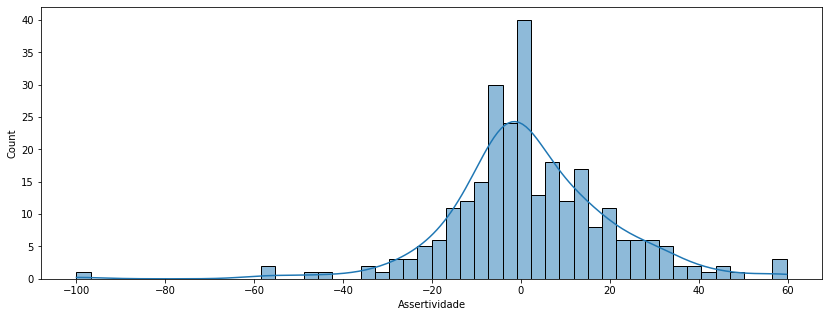

In [ ]:
fig=plt.figure(figsize=[14,5])
sns.histplot(base2['Assertividade'],bins=50,kde=True)
plt.show()

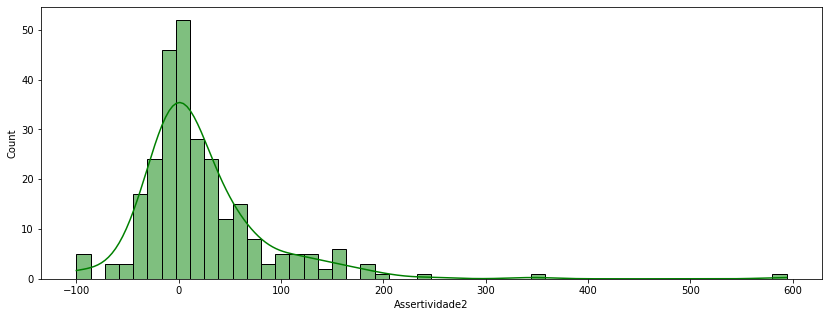

In [ ]:
fig=plt.figure(figsize=[14,5])
sns.histplot(base2['Assertividade2'],bins=50,kde=True, color='green')
plt.show()

<AxesSubplot:xlabel='total_hist', ylabel='Count'>

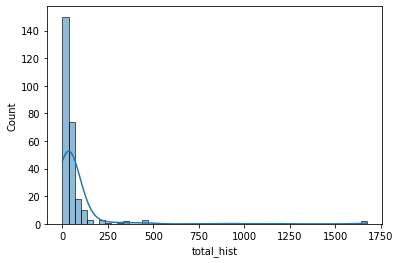

In [ ]:
sns.histplot(base2['total_hist'],bins=50,kde=True)

In [ ]:
# base2.to_excel('C:/Users/bruno/OneDrive/Área de Trabalho/Curso Data Expert DNC/AZUL/base2.xlsx')

In [ ]:
lin=dfTeste.loc[(dfTeste['chave2']=='2022-08-30NTUXDY10Y')]
# lin=dfTeste.iloc[1]
lin=lin.squeeze()
a=lin['NDO']
b=lin['Dep_Date']
c=lin['Segment']
# c=lin['FlightID']
d=lin['Periodo']
e=lin['Ocupacao']
f=lin['Flts']
g=lin['chave2']
h=lin['Nest']
j=lin['Dest']
k=lin['DOW']
m=lin['Capture']


subdf1=dforiglimpo2.loc[(dforiglimpo2['NDO']==a) & (dforiglimpo2['Dep_Date'].values<=b) & (dforiglimpo2['Segment']==c) &
      (dforiglimpo2['Periodo']==d)&(dforiglimpo2['Nest']==h)&(dforiglimpo2['Capture']<=m)&(dforiglimpo2['Finalizado']==1)]#&(dforiginal2['DOW']==k)]

subdfpred=dforiglimpo2.loc[(dforiglimpo2['chave2'].values==g)&(dforiglimpo2['Capture']==m)]

subdf1=pd.concat([subdfpred,subdf1])

     #Filtro de linhas que tenham a mesma caracteristica da linha selecionada anteriormente, porem com NDO = Zero
subdf2=dforiglimpo2.loc[(dforiglimpo2['NDO']==-1) & (dforiglimpo2['Dep_Date'].values<b) & (dforiglimpo2['Segment']==c) & (dforiglimpo2['Periodo']==d)&(dforiglimpo2['Nest']==h)]#&(dforiginal2['DOW']==k)]
y=subdf2[['chave2','Ocupacao']]

     #Merge das informações / contrução da Base de Treino

subdf3=pd.merge(subdf1,y,how='left',on='chave2')


subdf3=subdf3.drop(columns=['Flts', 'Rask','Dest','Capture'])
subdfpred = subdfpred.drop(columns=['Flts', 'Rask','Dest','Capture'])
subdfpred['Ocupacao_y']=0
subdfpred = subdfpred.set_index('chave2')

subdf3=subdf3.set_index('chave2')



In [ ]:
subdf3['Ocupacao_y'].mean(),subdf3['Ocupacao_y'].min(),subdf3['Ocupacao_y'].max()


(0.5926492819250656, 0.14705882350815053, 0.9714285714278795)

<AxesSubplot:xlabel='chave2'>

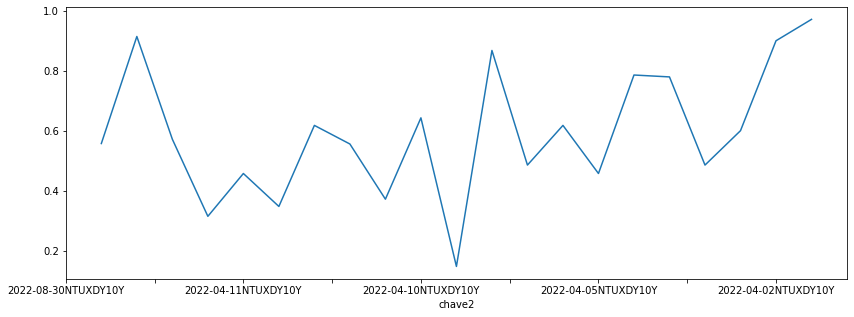

In [ ]:
fig=plt.figure(figsize=[14,5])
subdf3['Ocupacao_y'].plot()